# Faster R-CNN

## Utility Functions

In [ ]:
import torch
import torchvision
import cv2
import os
from coco_labels import get_coco_labels
import json
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

coco_labels = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', \
              'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 
              'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 
              'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella',
              'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard',
              'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
              'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass', 'cup', 'fork',
              'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange',
              'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch',
              'potted plant', 'bed', 'N/A', 'dining table', 'N/A', 'N/A', 'toilet',
              'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave',
              'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book', 'clock', 'vase',
              'scissors', 'teddy bear', 'hair drier', 'toothbrush']
coco_names = coco_labels.copy()
              
def read_image(dataset_dir, image_name):
    image = cv2.imread(dataset_dir + image_name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_boxes(image, boxes, labels, scores, coco_labels):
    for box, label, score in zip(boxes, labels, scores):
        box = [int(coord) for coord in box]
        score = float(score)
        cv2.rectangle(image, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
        # Convert label ID to corresponding class name
        class_name = coco_labels[label]
        if class_name == "N/A":
            continue
        text = "{}: {:.2f}".format(class_name, score)
        cv2.putText(image, text, (box[0], box[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    return image

def predict_boxes(model, image_tensor, confidence_threshold, iou_threshold):
    # Forward pass through the model
    output = model(image_tensor)

    # Visualize predictions on the image
    boxes, labels, scores = output[0]['boxes'], output[0]['labels'], output[0]['scores']

    # Apply confidence thresholding
    keep = scores > confidence_threshold
    boxes, labels, scores = boxes[keep], labels[keep], scores[keep]

    # Perform non-maximum suppression using NMS
    keep_idxs = torchvision.ops.nms(boxes, scores, iou_threshold=iou_threshold)

    # Apply NMS to retain the most confident detections
    boxes, labels, scores = boxes[keep_idxs], labels[keep_idxs], scores[keep_idxs]

    return boxes, labels, scores

def predict(input_tensor, model, detection_threshold):
    outputs = model(input_tensor)
    pred_classes = [coco_names[i] for i in outputs[0]['labels'].cpu().numpy()]
    pred_labels = outputs[0]['labels'].cpu().numpy()
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    
    boxes, classes, labels, indices = [], [], [], []
    for index in range(len(pred_scores)):
        if pred_scores[index] >= detection_threshold:
            boxes.append(pred_bboxes[index].astype(np.int32))
            classes.append(pred_classes[index])
            labels.append(pred_labels[index])
            indices.append(index)
    boxes = np.int32(boxes)
    return boxes, classes, labels, indices

def draw_boxes(boxes, labels, classes, image):
    for i, box in enumerate(boxes):
        cv2.rectangle(
            image,
            (int(box[0]), int(box[1])),
            (int(box[2]), int(box[3])),
            (0, 255, 0), 2
        )
        cv2.putText(image, classes[i], (int(box[0]), int(box[1] - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 0), 2,
                    lineType=cv2.LINE_AA)
    return image

## Inference & Evaluation (IoU & mAP)

The `torchvision.models.detection` module provides several pre-trained models for object detection, segmentation, and person keypoint detection, as well as some training utilities. For Faster R-CNN, the following models are available:

1. `fasterrcnn_resnet50_fpn`: This is a Faster R-CNN model with a ResNet-50 backbone and Feature Pyramid Network (FPN). It's pre-trained on the COCO train2017 dataset.

2. `fasterrcnn_mobilenet_v3_large_fpn`: This is a Faster R-CNN model with a MobileNetV3-Large backbone and FPN. It's also pre-trained on the COCO train2017 dataset.

3. `fasterrcnn_mobilenet_v3_large_320_fpn`: This is another Faster R-CNN model with a MobileNetV3-Large backbone and FPN, but designed for 320x320 input images. It's pre-trained on the COCO train2017 dataset.

You can use these models like this:



In [ ]:
def inference(images, model, transform, confidence_threshold, coco_labels, show=False, save=True, split='val'):

    output_dir = "output/" + split + "/confidence_threshold_" + str(confidence_threshold) + "/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for sample in images:
        image = np.array(Image.open(DATASET_DIR + sample))
        image_float_np = np.float32(image) / 255
        
        input_tensor = transform(image_float_np)
        input_tensor = input_tensor.unsqueeze(0)
        
        boxes, classes, labels, _ = predict(input_tensor, model, confidence_threshold)
        image = draw_boxes(boxes, labels, classes, image)
        
        if show:
            cv2.imshow("Image", image)
            cv2.waitKey(0)

        if save:
            cv2.imwrite(output_dir + sample, image)


# Constants
DATASET_DIR = "dataset/val2017/"
CONFIDENCE_THRESHOLD = 0.9
IOU_THRESHOLD = 0.5

# Load the COCO dataset in "dataset/test2017" 
test_images = os.listdir(DATASET_DIR)

# Load the pre-trained Faster R-CNN model trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

# Define the transformation to be applied to images
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Applying inference on the images
inference(test_images, model, transform, CONFIDENCE_THRESHOLD, coco_labels, show=False, save=True, split='val')

## Activation Visualization

Activation visualization is a technique used in deep learning to understand and analyze the behavior of neural networks. It involves visualizing the activations or outputs of individual neurons or layers within a neural network when given a particular input.

The main purpose of activation visualization is to gain insights into how the network is processing and representing the input data. By visualizing the activations, we can identify which parts of the input are being emphasized or ignored by the network. This can help us understand the network's decision-making process and potentially identify any issues or biases in the model.

In general, the process involves the following steps:

1. Load the pre-trained model: Activation visualization is typically performed on pre-trained models. The first step is to load the model architecture and weights.

2. Prepare the input data: Depending on the task, you need to prepare the input data that the model expects. This could involve preprocessing, resizing, or normalizing the input images.

3. Forward pass: Pass the input data through the model to obtain the activations. This involves feeding the input data through the layers of the model and collecting the activations at the desired layer(s).

4. Visualize the activations: Once you have obtained the activations, you can visualize them using various techniques such as heatmaps, feature maps, or activation histograms. These visualizations can provide insights into the learned representations and patterns within the network.

In [ ]:
def activation_visualization(images, model, transform, show=False, save=True, split='val'):
    # Set the model to evaluation mode
    model.eval()
    output_dir = "output/activation_visualization/" + split + "/"

    for sample in images:

        # Read the image from disk using the image_name
        image_name = sample
        image = read_image(DATASET_DIR, image_name)
        image_tensor = transform(image).unsqueeze(0)

        # Forward pass through the model
        output = model(image_tensor)

        # Get the feature maps from the model
        feature_maps = model.backbone.body(image_tensor)
        first_layer_activations = feature_maps['0'][0]
        last_layer_activations = feature_maps['3'][0]
        print("first_layer_activations: ", first_layer_activations.shape)
        print("last_layer_activations: ", last_layer_activations.shape)

        # Nomralize the activations
        first_layer_activations = (first_layer_activations - first_layer_activations.min()) / (first_layer_activations.max() - first_layer_activations.min())
        last_layer_activations = (last_layer_activations - last_layer_activations.min()) / (last_layer_activations.max() - last_layer_activations.min())
        
        # Visualize the activations
        fig, axes = plt.subplots(2, 3, figsize=(10, 5))

        # First layer activations for only the first 3 filters
        axes[0, 0].imshow(torchvision.transforms.ToPILImage()(first_layer_activations[0]), cmap="gray")
        axes[0, 0].set_title("First Layer Activations\nFilter 1")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(torchvision.transforms.ToPILImage()(first_layer_activations[1]), cmap="gray")
        axes[0, 1].set_title("First Layer Activations\nFilter 2")
        axes[0, 1].axis("off")

        axes[0, 2].imshow(torchvision.transforms.ToPILImage()(first_layer_activations[2]), cmap="gray")
        axes[0, 2].set_title("First Layer Activations\nFilter 3")
        axes[0, 2].axis("off")

        # Last layer activations for only the first 3 filters
        axes[1, 0].imshow(torchvision.transforms.ToPILImage()(last_layer_activations[0]), cmap="gray")
        axes[1, 0].set_title("Last Layer Activations\nFilter 1")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(torchvision.transforms.ToPILImage()(last_layer_activations[1]), cmap="gray")
        axes[1, 1].set_title("Last Layer Activations\nFilter 2")
        axes[1, 1].axis("off")

        axes[1, 2].imshow(torchvision.transforms.ToPILImage()(last_layer_activations[2]), cmap="gray")
        axes[1, 2].set_title("Last Layer Activations\nFilter 3")
        axes[1, 2].axis("off")

        plt.tight_layout()

        if save:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(output_dir + image_name)

        if show:
            plt.show()

# Constants
DATASET_DIR = "dataset/val2017/"
print("Loaded {} labels from COCO dataset".format(len(coco_labels)))

# Load the pre-trained Faster R-CNN model trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# Define the transformation to be applied to images
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the COCO dataset in "dataset/test2017"
test_images = os.listdir(DATASET_DIR)
test_images = test_images[:5]

# Apply activation visualization
activation_visualization(test_images, model, transform, show=True, save=True, split='val')

## Grad CAM


GRAD CAM (Gradient-weighted Class Activation Mapping) is a technique used to visualize and understand the regions of an image that are important for a deep learning model's prediction. It helps in interpreting the decision-making process of the model by highlighting the areas that contribute the most to the final prediction.

The main purpose of using GRAD CAM is to gain insights into how the model is focusing on specific regions of the input image to make its predictions. By visualizing the important regions, we can understand which parts of the image are influencing the model's decision and identify any biases or issues in the model.

To use GRAD CAM, you need to follow these steps:

1. Load the pre-trained model: In the provided code, a pre-trained Faster R-CNN model trained on the COCO dataset is loaded using `torchvision.models.detection.fasterrcnn_resnet50_fpn()`. This model is used for object detection.

2. Prepare the input data: The input images are loaded from the dataset directory and transformed using `torchvision.transforms.Compose()`.

3. Define the Grad CAM function: The `grad_cam()` function takes the images, model, transform, confidence threshold, IOU threshold, COCO labels, show flag, save flag, and split as input parameters. It sets the model to evaluation mode and defines the output directory for saving the results.

4. Iterate over the images: For each image, the function reads the image from disk, creates a copy of the original image, and transforms it into a tensor. The tensor is set to require gradients for backpropagation.

5. Predict boxes: The model predicts the bounding boxes, labels, and scores for the image using the `predict_boxes()` function.

6. Plot boxes: The function plots the predicted boxes on the image using the `plot_boxes()` function.

7. Backpropagate gradients: The gradients are backpropagated based on the predicted class scores. The model is zeroed out and the gradients are computed for each score.

8. Get activations and gradients: The activations from the last convolutional layer and the gradients of the output with respect to the last convolutional layer are obtained.

9. Compute Grad CAM heatmap: The Grad CAM heatmap is computed by multiplying the weights (mean values of gradients) with the last activation maps.

10. Normalize and resize Grad CAM heatmap: The Grad CAM heatmap is normalized and resized to match the input image size.

11. Visualize the results: The original image, predicted boxes, and Grad CAM heatmap are visualized using matplotlib.

12. Save or show the results: The results can be saved to the output directory or shown using the `save` and `show` flags.

By following these steps, you can use GRAD CAM to visualize and interpret the important regions in an image that contribute to the model's predictions.

In [ ]:
def grad_cam(images, model, transform, confidence_threshold, iou_threshold, coco_labels, show = False, save = True, split='val'):

    # Set the model to evaluation mode
    model.eval()
    output_dir = "output/gradcam/" + split + "/confidence_threshold_" + str(confidence_threshold) + "_iou_threshold_" + str(iou_threshold) + "/"

    for sample in images:

        # Read the image from disk using the image_name
        image_name = sample
        image = read_image(DATASET_DIR, sample)
        original_image = image.copy()
        image_tensor = transform(image).unsqueeze(0)
        image_tensor.requires_grad = True  

        boxes, labels, scores = predict_boxes(model, image_tensor, confidence_threshold, iou_threshold)

        if len(boxes) == 0:
            continue
        image = plot_boxes(image, boxes, labels, scores, coco_labels)

        # Backpropagate the gradients based on the predicted class score
        model.zero_grad()
        for score in scores:
            score.backward(retain_graph=True)
        
        # Get the activations from the last convolutional layer
        last_activation = model.backbone.body(image_tensor)['3'][0].detach().numpy()

        # Get the gradients of the output with respect to the last convolutional layer
        grads = model.backbone.body.layer4[2].conv3.weight.grad.detach().numpy()
        grads = grads.squeeze(axis=(2, 3))

        # Get the mean value of the gradients for every feature map
        weights = np.mean(grads, axis=(1))

        grad_cam = np.zeros(last_activation.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            grad_cam += w * last_activation[i, :, :]


        # Normalize Grad-CAM heatmap
        grad_cam = np.maximum(grad_cam, 0)
        grad_cam = (grad_cam - grad_cam.min()) / (grad_cam.max() - grad_cam.min())

        # Resize Grad-CAM heatmap to match the input image size
        grad_cam = cv2.resize(grad_cam, (image.shape[1], image.shape[0]))

        fig, axes = plt.subplots(1, 3, figsize=(10, 5))

        # Input image
        axes[0].imshow(original_image)
        axes[0].set_title("Input Image")
        axes[0].axis("off")

        # Predicted box within the image
        axes[1].imshow(image)
        axes[1].set_title("Predicted Boxes")
        axes[1].axis("off")

        # Grad-CAM heatmap
        axes[2].imshow(grad_cam, cmap='jet', alpha=0.5)
        axes[2].imshow(original_image, alpha=0.5)
        axes[2].set_title("Grad-CAM Heatmap")
        axes[2].axis("off")

        plt.tight_layout()

        if save:
            if not os.path.exists(output_dir):
                os.makedirs(output_dir)
            plt.savefig(output_dir + image_name)

        if show:
            plt.show()


# Constants
DATASET_DIR = "dataset/val2017/"
CONFIDENCE_THRESHOLD = 0.9
IOU_THRESHOLD = 0.5
coco_labels = get_coco_labels()
print("Loaded {} labels from COCO dataset".format(len(coco_labels)))

# Load the pre-trained Faster R-CNN model trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()

# Define the transformation to be applied to images
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Load the COCO dataset in "dataset/test2017"
test_images = os.listdir(DATASET_DIR)

# Apply Grad CAM
grad_cam(test_images, model, transform, CONFIDENCE_THRESHOLD, IOU_THRESHOLD, coco_labels, show=True, save=True, split='val')

## EigenCAM

Eigen-CAM is a method to generate class activation maps (CAMs) for convolutional neural networks (CNNs) using principal component analysis. The main steps to compute Eigen-CAM are:

1- Forward pass an image through a pretrained CNN model up to the last convolutional layer to obtain the feature maps (activations).

2- Reshape the feature maps into a matrix and perform singular value decomposition (SVD) on it to obtain the principal components.

3- Take the first principal component which corresponds to the direction of maximum variance in the data.

4- Reshape the principal component to the dimensions of the feature map to obtain the Eigen-CAM.

5- The Eigen-CAM highlights the regions in the image that contribute most to the CNN's output for a class.

In [ ]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')
import torchvision
from PIL import Image
import os
from pytorch_grad_cam.ablation_layer import AblationLayerFasterRCNN
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torchvision
from pytorch_grad_cam import GradCAM, AblationCAM, EigenCAM, ScoreCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import FasterRCNNBoxScoreTarget
from pytorch_grad_cam.utils.reshape_transforms import fasterrcnn_reshape_transform
from pytorch_grad_cam.utils.image import show_cam_on_image, scale_cam_image


def fasterrcnn_reshape_transform(x):
    target_size = x['pool'].size()[-2 : ]
    activations = []
    for key, value in x.items():
        activations.append(torch.nn.functional.interpolate(torch.abs(value), target_size, mode='bilinear'))
    activations = torch.cat(activations, axis=1)
    return activations

class FasterRCNNBoxScoreTarget:
    """ For every original detected bounding box specified in "bounding boxes",
        assign a score on how the current bounding boxes match it,
            1. In IOU
            2. In the classification score.
        If there is not a large enough overlap, or the category changed,
        assign a score of 0.

        The total score is the sum of all the box scores.
    """

    def __init__(self, labels, bounding_boxes, iou_threshold=0.5):
        self.labels = labels
        self.bounding_boxes = bounding_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, model_outputs):
        output = torch.Tensor([0])

        if len(model_outputs["boxes"]) == 0:
            return output

        for box, label in zip(self.bounding_boxes, self.labels):
            box = torch.Tensor(box[None, :])

            ious = torchvision.ops.box_iou(box, model_outputs["boxes"])
            index = ious.argmax()
            if ious[0, index] > self.iou_threshold and model_outputs["labels"][index] == label:
                score = ious[0, index] + model_outputs["scores"][index]
                output = output + score
        return output
    
def renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_cam):
    """Normalize the CAM to be in the range [0, 1] 
    inside every bounding boxes, and zero outside of the bounding boxes. """
    renormalized_cam = np.zeros(grayscale_cam.shape, dtype=np.float32)
    images = []
    for x1, y1, x2, y2 in boxes:
        img = renormalized_cam * 0
        img[y1:y2, x1:x2] = scale_cam_image(grayscale_cam[y1:y2, x1:x2].copy())    
        images.append(img)
    
    renormalized_cam = np.max(np.float32(images), axis = 0)
    renormalized_cam = scale_cam_image(renormalized_cam)
    eigencam_image_renormalized = show_cam_on_image(image_float_np, renormalized_cam, use_rgb=True)
    image_with_bounding_boxes = draw_boxes(boxes, labels, classes, eigencam_image_renormalized)
    return image_with_bounding_boxes

In [ ]:
DATASET_DIR = "dataset/val2017/"
test_images = os.listdir(DATASET_DIR)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
target_layers = [model.backbone]

Eigencam = EigenCAM(model,
               target_layers, 
               reshape_transform=fasterrcnn_reshape_transform)

for image in test_images:
    image_name = image
    image = np.array(Image.open(DATASET_DIR + image))
    original_image = image.copy()
    image_float_np = np.float32(image) / 255
    
    input_tensor = transform(image_float_np)
    input_tensor = input_tensor.unsqueeze(0)

    # Run the model and display the detections
    boxes, classes, labels, indices = predict(input_tensor, model, 0.9)
    targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

    image_with_predictions = draw_boxes(boxes, labels, classes, image)

    # Computing EigenCAM
    grayscale_eigencam = Eigencam(input_tensor=input_tensor, targets=targets)[0, :]
    eigencam_image = show_cam_on_image(image_float_np, grayscale_eigencam, use_rgb=True)
    if len(boxes) == 0:
        continue
    renormalized_eigencam_image = renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_eigencam)

    fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Image with predicted bounding boxes
    axes[1].imshow(image_with_predictions)
    axes[1].set_title("Predicted Boxes")
    axes[1].axis("off")

    # EigenCAM heatmap
    axes[2].imshow(eigencam_image)
    axes[2].set_title("EigenCAM Heatmap")
    axes[2].axis("off")

    # EigenCAM heatmap renormalized in bounding boxes
    axes[3].imshow(renormalized_eigencam_image)
    axes[3].set_title("EigenCAM Heatmap\nRenormalized in Bounding Boxes")
    axes[3].axis("off")


    plt.tight_layout()
    # Saving the images
    output_dir = "output/eigencam/val/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(output_dir + image_name)
    plt.show()

## AblationCAM

100%|██████████| 1/1 [00:26<00:00, 26.92s/it]


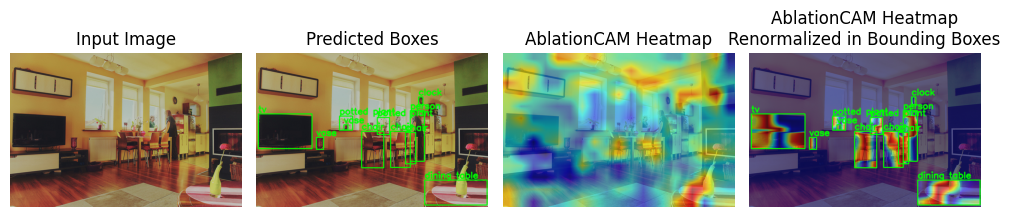

100%|██████████| 1/1 [00:17<00:00, 17.28s/it]


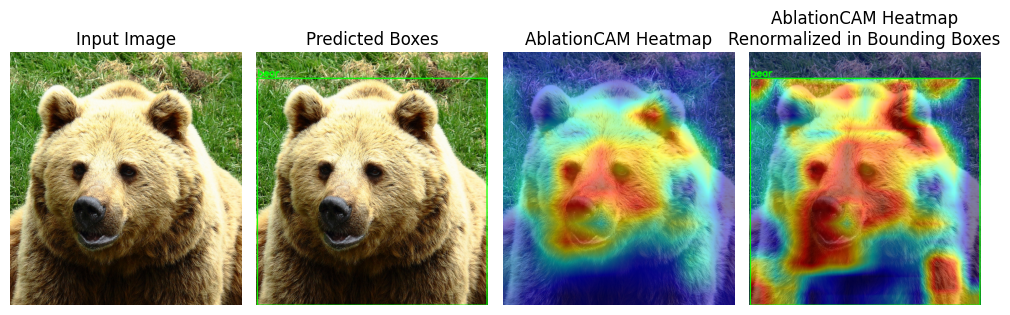

100%|██████████| 1/1 [00:18<00:00, 18.33s/it]


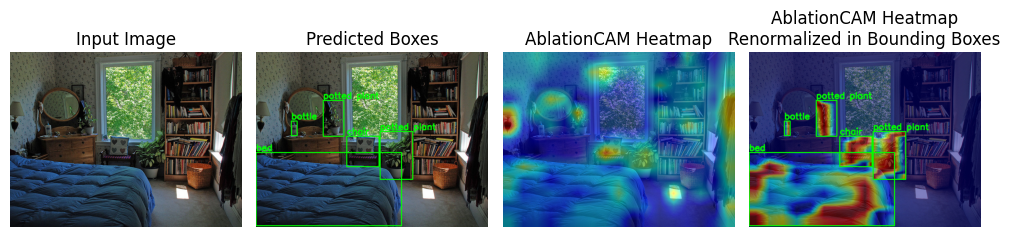

100%|██████████| 1/1 [00:17<00:00, 17.09s/it]


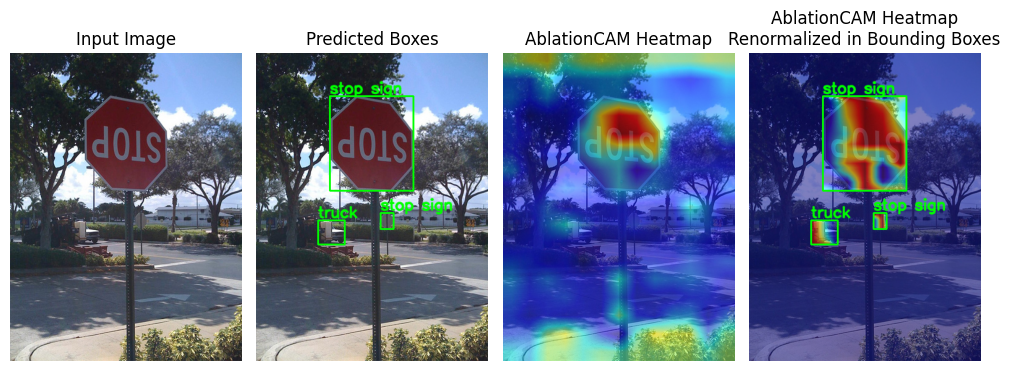

  0%|          | 0/1 [00:00<?, ?it/s]

In [36]:
DATASET_DIR = "dataset/val2017/"
test_images = os.listdir(DATASET_DIR)
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
target_layers = [model.backbone]

Ablationcam = AblationCAM(model,
                  target_layers, 
                  reshape_transform=fasterrcnn_reshape_transform,
                  ablation_layer=AblationLayerFasterRCNN(),
                  ratio_channels_to_ablate=0.01)

for image in test_images:
    image_name = image
    image = np.array(Image.open(DATASET_DIR + image))
    original_image = image.copy()
    image_float_np = np.float32(image) / 255
    
    input_tensor = transform(image_float_np)
    input_tensor = input_tensor.unsqueeze(0)

    # Run the model and display the detections
    boxes, classes, labels, indices = predict(input_tensor, model, 0.9)
    targets = [FasterRCNNBoxScoreTarget(labels=labels, bounding_boxes=boxes)]

    image_with_predictions = draw_boxes(boxes, labels, classes, image)

    # Computing AblationCAM
    grayscale_ablationcam = Ablationcam(input_tensor=input_tensor, targets=targets)[0, :]
    ablationcam = show_cam_on_image(image_float_np, grayscale_ablationcam, use_rgb=True)
    if len(boxes) == 0:
        continue
    renormalized_ablationcam = renormalize_cam_in_bounding_boxes(boxes, image_float_np, grayscale_ablationcam)

    fig, axes = plt.subplots(1, 4, figsize=(10, 5))
    axes[0].imshow(original_image)
    axes[0].set_title("Input Image")
    axes[0].axis("off")

    # Image with predicted bounding boxes
    axes[1].imshow(image_with_predictions)
    axes[1].set_title("Predicted Boxes")
    axes[1].axis("off")

    # AblationCAM heatmap
    axes[2].imshow(ablationcam)
    axes[2].set_title("AblationCAM Heatmap")
    axes[2].axis("off")

    # AblationCAM heatmap renormalized in bounding boxes
    axes[3].imshow(renormalized_ablationcam)
    axes[3].set_title("AblationCAM Heatmap\nRenormalized in Bounding Boxes")
    axes[3].axis("off")


    plt.tight_layout()
    # Saving the images
    output_dir = "output/ablation/val/"
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    plt.savefig(output_dir + image_name)
    plt.show()